In [1]:
# Loading the required packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap 
import seaborn as sns
from scipy.stats import pearsonr
import requests
from bs4 import BeautifulSoup
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.lines import Line2D
import networkx as nx
from sklearn.model_selection import train_test_split, GridSearchCV      
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay

For this coursework, the latest data, years 2005 to 2007, will be used for analysis. Year 2008 data is not selected as it only included flights up till April. The reason for the selection of the latest available data is to simulate real-world analysis, with the recovery of commercial air travel post 9/11, and especially the rise of low-cost carriers during the period.

In [2]:
years_of_interest = list(range(2005,2008)) # Specifying the years of data that we are interested in (2005-2007).

df = pd.DataFrame()
for i in years_of_interest:
    df = df.append(pd.read_csv(str(i) + ".csv"))
    
# Removing flights which are either diverted or cancelled.
df = df[(df['Cancelled']==0) & (df['Diverted']==0)]

In [3]:
# Checking if there are any flights with invalid ArrDelay or DepDelay data
df['ArrDelay'].isna().any() # There are no NA's
df['DepDelay'].isna().any() # There are no NA's

False

<a id='q1'></a>
# Q1) When is the best time of day, day of the week, and time of year to fly to minimise delays? 

## Q1a) Best time of the day to fly to minimise delays

To answer this question, only the arrival delay will be taken into consideration. As consumers, we are most concerned about whether we reach our destination on time and not so much about whether the aircraft has departed late. There are flights which had departed late but still managed to arrive early. This means that despite departing late, some flights can make it up by travelling at a faster speed and arrive on time. Hence, only arrival delay will be taken into consideration. The arrival delay will be averaged out to determine the best period to fly to minimise delays.

Getting the average delay for every hourly interval

In [4]:
# Checking if there are any missing CRSDepTime
df['CRSDepTime'].isna().any() # There are no NA's

df1 = df.copy()

# Adding a column 'HourOfDay' to specify the hour interval the scheduled departure time (CRSDepTime) is in. 
df1['CRSDepTime'] = df1['CRSDepTime'].astype(str)
length_of_crsdeptime = df1['CRSDepTime'].str.len()
df1['HourOfDay'] = np.select([length_of_crsdeptime==4, length_of_crsdeptime==3, length_of_crsdeptime<3], [df1['CRSDepTime'].str[0:2], df1['CRSDepTime'].str[0:1], 0], np.nan)
df1['HourOfDay'] = df1['HourOfDay'].astype(int)
# For example, if CRSDepTime is 1234, it represents 12:34PM and HourOfDay will be 12. 
# If CRSDepTime is 123, it represents 1:23AM and HourOfDay will be 1. 
#If CRSDepTime is 12, it represents 12:12AM and HourOfDay will be 0. 
# If CRSDepTime is 1, it represents 12:01AM and HourOfDay will be 0.

df1['HourOfDay'].isna().any() # There are no NA's

d1 = df1.groupby('HourOfDay', as_index=False).agg(Hour_AvgDelay=('ArrDelay', 'mean'))
d1

,HourOfDay,Hour_AvgDelay
0,0,3.519219
1,1,2.476450
2,2,2.354043
3,3,11.603878
4,4,4.712358
5,5,-0.154913
6,6,0.353426
7,7,1.488548
8,8,2.783525
9,9,3.819828



From the table above, we can see that arrival delays peak around 5-8pm (1700-2000hrs) scheduled departure time. However, there is a huge spike in average arrival delay for flights scheduled to depart between 3-4am. We should check if there could be any invalid or erroneous data that may explain the sudden surge.

In [5]:
# Viewing the flights scheduled to depart between 3-4am with the highest ArrDelay to see if there could be 
# any invalid or erroneous data.
df1[['Year', 'Month','DayofMonth','DayOfWeek','DepDelay', 'ArrDelay' ,'HourOfDay']][df1['HourOfDay']==3].sort_values(by=['ArrDelay'], ascending=False).head()

,Year,Month,DayofMonth,DayOfWeek,DepDelay,ArrDelay,HourOfDay
4053862,2006,7,22,6,639.0,680.0,3
4056600,2006,7,28,5,227.0,239.0,3
3458472,2006,6,28,3,199.0,231.0,3
3436199,2006,6,25,7,215.0,218.0,3
3426891,2006,6,2,5,201.0,217.0,3


From the table above, we can see that there is an extreme outlier of a flight on 22 July 2006 with 680 minutes arrival delay, mainly caused by the departure delay of 639 minutes. With this information, we can check whether other flights on the same day at similar hours experienced similar extreme delays, which could imply unusual circumstance that may justify the removal of these data.

In [6]:
df1[['Year', 'Month','DayofMonth','DayOfWeek','DepDelay', 'ArrDelay' ,'HourOfDay']][(df1['Year']==2006) & (df1['Month']==7) & (df1['DayofMonth']==22) & (df1['HourOfDay'].isin([2,3,4]))].sort_values(by=['DepDelay'], ascending=False).head()

,Year,Month,DayofMonth,DayOfWeek,DepDelay,ArrDelay,HourOfDay
4053862,2006,7,22,6,639.0,680.0,3
4081727,2006,7,22,6,209.0,209.0,3
4053488,2006,7,22,6,165.0,149.0,4
4043364,2006,7,22,6,19.0,26.0,2
4043599,2006,7,22,6,1.0,8.0,2


From the table, we can see that of the flights scheduled to depart on the same day, 
between 2am and 5am, had no extreme outliers like the one with 639 minutes departure delay. This suggests that there are no reasons to remove that data and the data above is valid.

Plotting Average Arrival Delay vs Hour of Day


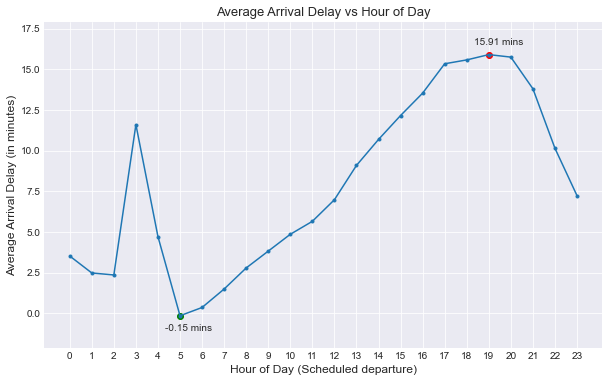

In [7]:
plt.style.use('seaborn-darkgrid')

plt.figure(figsize=(10,6))
plt.plot(d1['HourOfDay'], d1['Hour_AvgDelay'], '.-')
plt.scatter(x=d1.loc[d1['Hour_AvgDelay'] == min(d1['Hour_AvgDelay'])]['HourOfDay'], y=d1.loc[d1['Hour_AvgDelay'] == min(d1['Hour_AvgDelay'])]['Hour_AvgDelay'], c="green") # create a point to show minimum delay
plt.scatter(x=d1.loc[d1['Hour_AvgDelay'] == max(d1['Hour_AvgDelay'])]['HourOfDay'], y=d1.loc[d1['Hour_AvgDelay'] == max(d1['Hour_AvgDelay'])]['Hour_AvgDelay'], c="red") # create a point to show maximum delay
plt.annotate(str(round(min(d1['Hour_AvgDelay']),2)) + " mins", xy=(d1[d1['Hour_AvgDelay'] == min(d1['Hour_AvgDelay'])]['HourOfDay'], d1[d1['Hour_AvgDelay'] == min(d1['Hour_AvgDelay'])]['Hour_AvgDelay']), xytext=(-15, -15), textcoords='offset pixels') # create text label for min delay 
plt.annotate(str(round(max(d1['Hour_AvgDelay']),2)) + " mins", xy=(d1[d1['Hour_AvgDelay'] == max(d1['Hour_AvgDelay'])]['HourOfDay'], d1[d1['Hour_AvgDelay'] == max(d1['Hour_AvgDelay'])]['Hour_AvgDelay']), xytext=(-15, 10), textcoords='offset pixels') # create text label for max delay 
plt.ylim(bottom=min(d1['Hour_AvgDelay'])-2, top=max(d1['Hour_AvgDelay'])+2) # extend y limits so the text label has some extra room
plt.title("Average Arrival Delay vs Hour of Day", size=13)
plt.xlabel("Hour of Day (Scheduled departure)", size=12)
plt.ylabel("Average Arrival Delay (in minutes)", size=12)
plt.xticks(d1['HourOfDay'])

plt.show()

As we can see from the graph above, the minimal average delay is -0.15 minutes (0.15 minutes early) on flights scheduled to depart between 5am and 6am.


Plotting Average Delays vs Hour and Day

In [8]:
# Creating a function to change variable DayOfWeek into words.
def DayOfWeek_to_words(datatable):
    for i in range(0,len(datatable)):
        if datatable.loc[i, 'DayOfWeek'] == 1:
            datatable.loc[i, 'DayOfWeek'] = "Monday"
        elif datatable.loc[i, 'DayOfWeek'] == 2:
            datatable.loc[i, 'DayOfWeek'] = "Tuesday"
        elif datatable.loc[i, 'DayOfWeek'] == 3:
            datatable.loc[i, 'DayOfWeek'] = "Wednesday"
        elif datatable.loc[i, 'DayOfWeek'] == 4:
            datatable.loc[i, 'DayOfWeek'] = "Thursday"
        elif datatable.loc[i, 'DayOfWeek'] == 5:
            datatable.loc[i, 'DayOfWeek'] = "Friday"
        elif datatable.loc[i, 'DayOfWeek'] == 6:
            datatable.loc[i, 'DayOfWeek'] = "Saturday"
        elif datatable.loc[i, 'DayOfWeek'] == 7:
            datatable.loc[i, 'DayOfWeek'] = "Sunday"
    return datatable
    
d1_daily = df1.groupby(['DayOfWeek', 'HourOfDay'], as_index=False).agg(HourlyDaily_AvgDelay=('ArrDelay', 'mean'))
d1_daily = DayOfWeek_to_words(d1_daily)

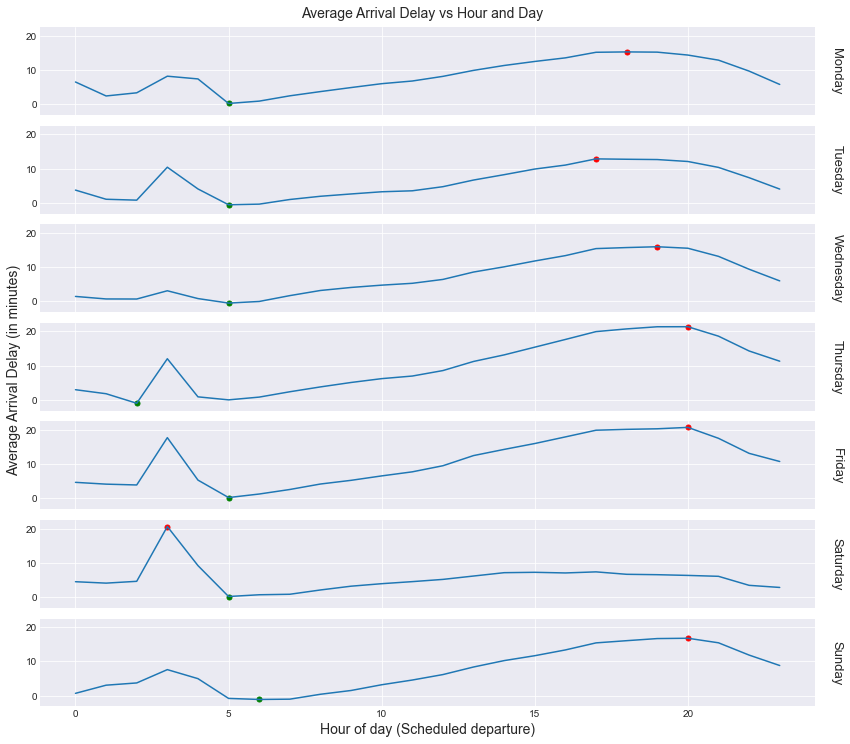

In [9]:
def plotmaxmin(data, **kws): # to plot min and max points on the plot
    plt.scatter(x=data.loc[data['HourlyDaily_AvgDelay'] == min(data['HourlyDaily_AvgDelay'])]['HourOfDay'], y=data.loc[data['HourlyDaily_AvgDelay'] == min(data['HourlyDaily_AvgDelay'])]['HourlyDaily_AvgDelay'], c="green", s=25) # create a point to show minimum delay
    plt.scatter(x=data.loc[data['HourlyDaily_AvgDelay'] == max(data['HourlyDaily_AvgDelay'])]['HourOfDay'], y=data.loc[data['HourlyDaily_AvgDelay'] == max(data['HourlyDaily_AvgDelay'])]['HourlyDaily_AvgDelay'], c="red", s=25) # create a point to show maximum delay
g = sns.FacetGrid(data=d1_daily, row='DayOfWeek', height=1.5, aspect=8, margin_titles=True)
g = g.map(plt.plot, 'HourOfDay', 'HourlyDaily_AvgDelay')
g.map_dataframe(plotmaxmin)
plt.subplots_adjust(hspace=0)

g.fig.suptitle("Average Arrival Delay vs Hour and Day", size=14)
g.set_titles(row_template = '{row_name}', size=13)
g.fig.subplots_adjust(top=0.96)
g.set(ylabel=None)
g.fig.supylabel("Average Arrival Delay (in minutes)", size=14)
plt.xlabel("Hour of day (Scheduled departure)", size=14)
g.set(ylim=(min(d1_daily['HourlyDaily_AvgDelay']-2), None))

plt.tight_layout()
plt.show()

From this graph, we can see the minimal delay occurs for flights scheduled to depart between 5am to 6am on most days which confirms the previous result.

We can conclude that the best time of the day to fly to minimise delays is between 5am and 6am.

##  Q1b) Best day of the week to fly to minimise delays

Creating a summary table for the Average Total Delay arranged by Day of the week.

In [10]:
d2 = df1.groupby('DayOfWeek', as_index=False).agg(Daily_AvgDelay=('ArrDelay', 'mean'))
d2 = DayOfWeek_to_words(d2)
d2

,DayOfWeek,Daily_AvgDelay
0,Monday,9.100250
1,Tuesday,6.628301
2,Wednesday,8.517657
3,Thursday,11.330628
4,Friday,11.654077
5,Saturday,4.776150
6,Sunday,8.335905


Plotting Average Delay vs Day of Week

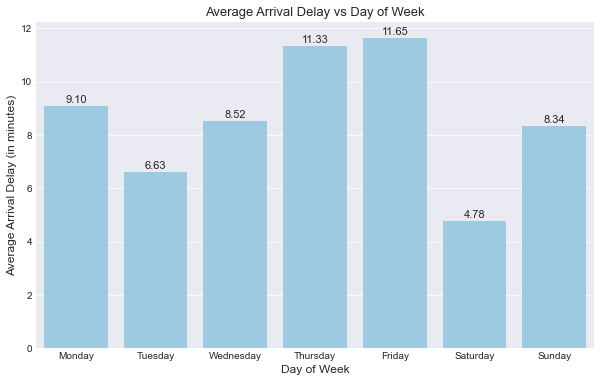

In [11]:
plt.figure(figsize=(10,6))
plt.title("Average Arrival Delay vs Day of Week", size=13)
daily_bars = sns.barplot(data=d2, x='DayOfWeek', y='Daily_AvgDelay', color="#9ECAE1", saturation=1)
plt.xlabel("Day of Week", size=12)
plt.ylabel("Average Arrival Delay (in minutes)", size=12)

for bar in daily_bars.patches:
    daily_bars.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   xytext=(0, 6),
                   textcoords='offset points', size=11) # create text labels
plt.show()

Getting the lowest minimum average delay

In [12]:
d2_MinDelay = d2[d2['Daily_AvgDelay']==min(d2['Daily_AvgDelay'])].reset_index(drop=True)

print(d2_MinDelay['DayOfWeek'][0], "has the lowest average delay of", round(d2_MinDelay['Daily_AvgDelay'][0],2), "minutes.")

Saturday has the lowest average delay of 4.78 minutes.


Creating a summary table for the Average Total Delay arranged by Day of the week and Year.

In [13]:
d2_yearly = df1.groupby(['DayOfWeek', 'Year'], as_index=False).agg(YearlyDaily_AvgDelay=('ArrDelay', 'mean'))
DayOfWeek_to_words(d2_yearly)

,DayOfWeek,Year,YearlyDaily_AvgDelay
0,Monday,2005,7.860761
1,Monday,2006,8.842539
2,Monday,2007,10.513503
3,Tuesday,2005,5.367869
4,Tuesday,2006,6.195163
5,Tuesday,2007,8.263684
6,Wednesday,2005,7.556946
7,Wednesday,2006,7.977179
8,Wednesday,2007,9.962944
9,Thursday,2005,9.672332


Plotting Average Delay vs Day of Week of every year


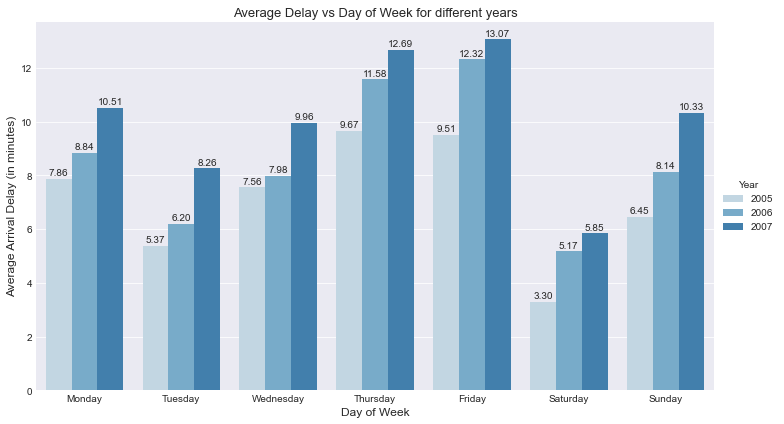

In [14]:
color1 = ["#BDD7E7", "#6BAED6", "#3182BD"]
plt.figure(figsize=(11, 6))
yearlydaily_plot = sns.barplot(data=d2_yearly, x='DayOfWeek', y='YearlyDaily_AvgDelay', hue='Year', palette=color1)
plt.title("Average Delay vs Day of Week for different years", size=13)
plt.xlabel("Day of Week", size=12)
plt.ylabel("Average Arrival Delay (in minutes)", size=12)

for bar in yearlydaily_plot.patches:
    yearlydaily_plot.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   xytext=(0, 6),
                   textcoords='offset points',size=10) # create text labels
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left', title="Year") # set legend outside of plot
plt.tight_layout()
plt.show()

Saturdays have the lowest average arrival delay *consistently* throughout the years which confirms the previous result. 
We can conclude that the best day of the week to fly to minimise delays is on Saturday.

## Q1c) Best time of the year to fly to minimise delays

To find out the best time of the year to fly to minimise delays, two analyses will be done. For the first analysis, the year will be categorized into meteorological seasons to find out the best season to fly to minimise delays. Spring runs from March to May, Summer from June to August, Autumn from September to November, and Winter from December to February. The other analysis looks into the best month to fly to minimise delays. 

Plotting Average Delay vs Day of week, based on seasons. 

In [15]:
month_season_df = pd.DataFrame({'Month': list(range(1,13)), 
                              'Season': ["Winter", "Winter", "Spring", "Spring", "Spring", "Summer", "Summer", "Summer", "Autumn", "Autumn", "Autumn", "Winter"]})
df1 = df1.merge(month_season_df, how='left', on='Month')

d3_season_daily = df1.groupby(['DayOfWeek', 'Season'], as_index=False).agg(SeasonDaily_AvgDelay=('ArrDelay', 'mean'))
DayOfWeek_to_words(d3_season_daily)

,DayOfWeek,Season,SeasonDaily_AvgDelay
0,Monday,Autumn,7.635620
1,Monday,Spring,5.831070
2,Monday,Summer,12.607534
3,Monday,Winter,10.298106
4,Tuesday,Autumn,5.110246
5,Tuesday,Spring,4.277219
6,Tuesday,Summer,11.045479
7,Tuesday,Winter,5.999887
8,Wednesday,Autumn,5.994290
9,Wednesday,Spring,7.394034


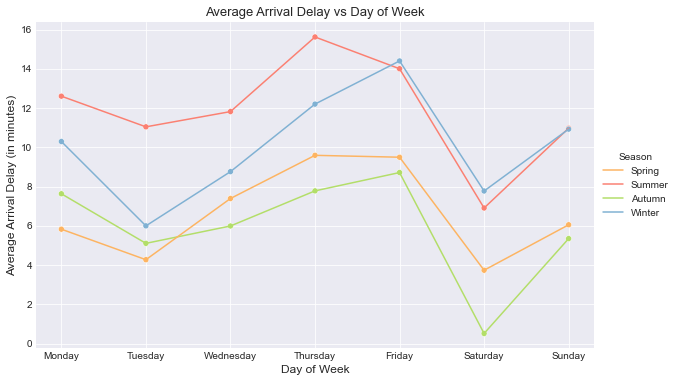

In [16]:
color2 = {'Spring': "#FDB462",
          'Summer': "#FB8072",
          'Autumn': "#B3DE69",
          'Winter': "#80B1D3"}

plt.figure(figsize=(10,6))
seasondaily_plot = sns.lineplot(data=d3_season_daily, x='DayOfWeek', y='SeasonDaily_AvgDelay', hue='Season', palette=color2)
sns.scatterplot(data=d3_season_daily, x='DayOfWeek', y='SeasonDaily_AvgDelay', hue='Season', palette=color2, legend=False)
handles, labels = seasondaily_plot.get_legend_handles_labels() # to change order of legend
handles = [handles[1], handles[2], handles[0], handles[3]] # to change order of legend
labels = [labels[1], labels[2], labels[0], labels[3]]  # to change order of legend
plt.legend(handles, labels, bbox_to_anchor=(1, 0.5), loc='center left', title="Season")  # set legend outside of plot
plt.title("Average Arrival Delay vs Day of Week", size=13)
plt.xlabel("Day of Week", size=12)
plt.ylabel("Average Arrival Delay (in minutes)", size=12)

plt.show()

From the graph, we can see that most days in Autumn have the lowest average arrival delay. 

Plotting the Average Arrival Delay based on seasons.

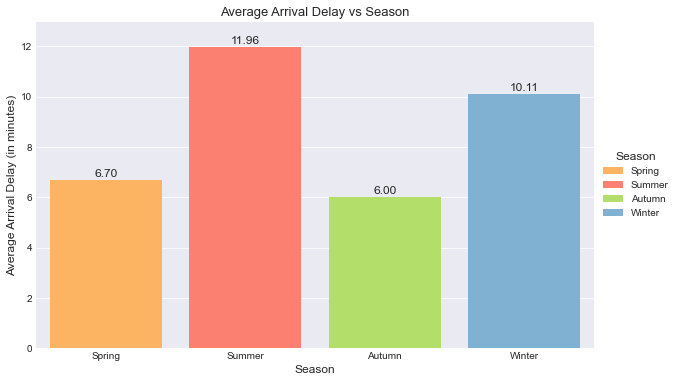

In [17]:
d3_season = df1.groupby('Season', as_index=False).agg(Season_AvgDelay = ('ArrDelay', 'mean')).sort_values(by=['Season_AvgDelay'], ascending=False).reset_index(drop=True)

plt.figure(figsize=(10,6))
season_plot = sns.barplot(data=d3_season, x='Season', y='Season_AvgDelay', hue='Season', dodge=False,  order=["Spring", "Summer", "Autumn", "Winter"], palette=color2, saturation=1)
handles, labels = season_plot.get_legend_handles_labels() # to change order of legend
handles = [handles[2], handles[0], handles[3], handles[1]] # to change order of legend
labels = [labels[2], labels[0], labels[3], labels[1]] # to change order of legend
for bar in season_plot.patches:
    season_plot.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   xytext=(0, 6),
                   textcoords='offset points', size=12) # create text labels 
plt.legend(handles, labels, bbox_to_anchor=(1, 0.5), loc='center left', title="Season", title_fontsize=12) # set legend outside of plot
plt.title("Average Arrival Delay vs Season", size=13)
plt.xlabel("Season", size=12)
plt.ylabel("Average Arrival Delay (in minutes)", size=12)
plt.ylim(top=max(d3_season['Season_AvgDelay'])+1) # extend y limit so the text label has some extra room
plt.show()

In [18]:
d3_season_MinDelay = d3_season[d3_season['Season_AvgDelay']==min(d3_season['Season_AvgDelay'])].reset_index(drop=True)

print(d3_season_MinDelay['Season'][0], "has the lowest average delay of", round(d3_season_MinDelay['Season_AvgDelay'][0],2), "minutes.")

Autumn has the lowest average delay of 6.0 minutes.


We can conclude that the best season to fly to minimise delays is in Autumn.

We can also look deeper and analyze the delays by months.

Plotting Average Arrival Delay by Month

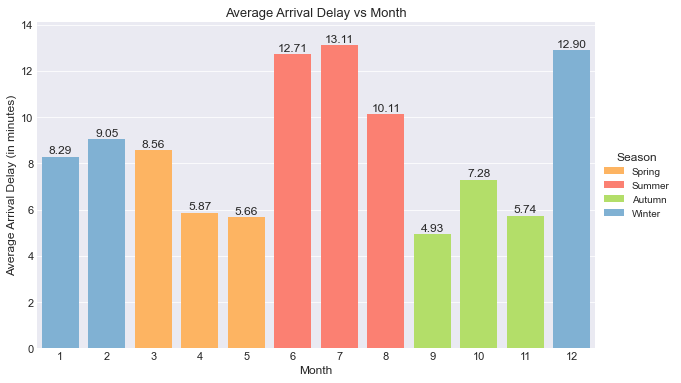

In [19]:
d3_season_monthly = df1.groupby(['Month', 'Season'], as_index=False).agg(Monthly_AvgDelay=('ArrDelay', 'mean')).sort_values(by=['Monthly_AvgDelay'], ascending=False).reset_index(drop=True)

plt.figure(figsize=(10,6))
season_monthly_plot = sns.barplot(data=d3_season_monthly, x='Month', y='Monthly_AvgDelay', hue='Season', palette=color2, saturation=1, dodge=False, ci=None)
handles, labels = season_monthly_plot.get_legend_handles_labels() # to change order of legend
handles = [handles[2], handles[0], handles[3], handles[1]] # to change order of legend
labels = [labels[2], labels[0], labels[3], labels[1]] # to change order of legend
for bar in season_monthly_plot.patches:
    season_monthly_plot.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   xytext=(0, 6),
                   textcoords='offset points', size=12) # create text labels 
plt.legend(handles, labels, bbox_to_anchor=(1, 0.5), loc='center left', title="Season", title_fontsize=12) # set legend outside of plot
plt.title("Average Arrival Delay vs Month", size=13)
plt.xlabel("Month", size=12)
plt.ylabel("Average Arrival Delay (in minutes)", size=12)
plt.xticks(size=11)
plt.yticks(size=11)
plt.ylim(top=max(d3_season_monthly['Monthly_AvgDelay'])+1) # extend y limit so the text label has some extra room
plt.show()

From the graph, we can see that summer months and holiday season (around December) are bad times to fly.

In [20]:
d3_season_monthly_MinDelay = d3_season_monthly[d3_season_monthly['Monthly_AvgDelay']==min(d3_season_monthly['Monthly_AvgDelay'])].reset_index(drop=True)

print("Month", (d3_season_monthly_MinDelay['Month'][0]), "has the lowest average delay of", round(d3_season_monthly_MinDelay['Monthly_AvgDelay'][0],2), "minutes.")

Month 9 has the lowest average delay of 4.93 minutes.


We can conclude that the best month of the year to fly to minimise delays is in September.


# Q2) Do older planes suffer more delays?

In [21]:
# Reading plane-data.csv into a dataframe. 
plane_data = pd.read_csv("plane-data.csv")
plane_data.head()

,tailnum,type,manufacturer,issue_date,model,status,aircraft_type,engine_type,year
0,N050AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,N051AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,N052AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,N054AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,N055AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It is evident that there are missing data.

The following data processing procedures will be done:

- Checking for invalid or erroneous data
- Removing columns that are irrelevant for this analysis
- Removing records where there are missing or invalid data

In [22]:
# Checking if there are any duplicated tailnum.
any(plane_data['tailnum'].duplicated()) # False means that there are no duplicated tailnum.

False

Removing variables that are irrelevant for this analysis. Variable 'year' is kept instead of 'issue_date' as 'issue_date' is the day when the airplane certification is issued, while year is the year that the aircraft was built. This information was cross-checked at airport-data.com

In [23]:
plane_data = plane_data[['tailnum', 'year']] # Keeping only columns tailnum and year
plane_data = plane_data.rename(columns={"year": "year_built"}) # Changing the variable 'year' to 'year_built' to avoid confusion when joined with flights dataframe
plane_data.head()

,tailnum,year_built
0,N050AA,NaN
1,N051AA,NaN
2,N052AA,NaN
3,N054AA,NaN
4,N055AA,NaN


Removing rows where there are missing data.

In [24]:
plane_data.isna().sum() # There are 549 rows with missing year_built

# Keeping only rows with non-missing data
plane_data = plane_data.dropna()
plane_data.isna().sum() # There are now 0 rows with missing data

tailnum       0
year_built    0
dtype: int64

In [25]:
plane_data.sort_values(by=['year_built']) # We can see that there is year_built of "None" and "0000"

,tailnum,year_built
1489,N384AE,0000
725,N235SW,0000
962,N298AE,0000
4533,N9149E,1946
1473,N381AA,1956
...,...,...
1972,N47414,None
1089,N323AE,None
2210,N512AE,None
647,N211NE,None


In [26]:
plane_data = plane_data.loc[(plane_data['year_built']!="None") & (plane_data['year_built']!="0000")] # Removing records with year_built of '0000' and 'None'

Joining plane_data with the flights dataframe by Tail Number.

In [27]:
df2 = df.join(plane_data.set_index('tailnum'), how='inner', on='TailNum')

df2['year_built'].isna().sum() # There are no NA's

# Calculating the age of the plane at the time of flying
df2['year_built'] = df2['year_built'].astype('int') # Converting year_built to integer for calculation
df2['AgeOfPlane'] = df2['Year'] - df2['year_built'] 
df2['AgeOfPlane'].describe() # There is a negative minimum AgeOfPlane which does not make sense.

count    1.648675e+07
mean     9.398322e+00
std      7.302437e+00
min     -2.000000e+00
25%      4.000000e+00
50%      7.000000e+00
75%      1.400000e+01
max      5.100000e+01
Name: AgeOfPlane, dtype: float64

Checking tail numbers that have negative AgeOfPlane.

In [28]:
df2.loc[df2['AgeOfPlane'] < 0][['TailNum','Year','AgeOfPlane', 'year_built']].drop_duplicates()  

,TailNum,Year,AgeOfPlane,year_built
446160,N394AA,2005,-2,2007
436074,N394AA,2006,-1,2007
446173,N395AA,2005,-2,2007
436075,N395AA,2006,-1,2007
450097,N544AA,2005,-2,2007
439359,N544AA,2006,-1,2007


We can see that TailNum N394AA, N395AA, and N544AA were built in 2007 but are present in the 2005 and 2006 datasets which does not make sense. Further checking at at airport-data.com and aviationdb.net also showed the same year of manufacture. This implies that they may be errors in the dataset. For this analysis, we will remove these 3 tail numbers.

In [29]:
# Removing tail numbers with negative AgeOfPlane.
remove_flights = df2.loc[df2['AgeOfPlane'] < 0]['TailNum'].unique().tolist()
df2 = df2[-df2['TailNum'].isin(remove_flights)]
df2['AgeOfPlane'].describe() # There is no more negative minimum AgeOfPlane

count    1.648112e+07
mean     9.401877e+00
std      7.301136e+00
min      0.000000e+00
25%      4.000000e+00
50%      7.000000e+00
75%      1.400000e+01
max      5.100000e+01
Name: AgeOfPlane, dtype: float64

The delay for this analysis will be calculated by ArrDelay - CarrierDelay - WeatherDelay - NASDelay – SecurityDelay - LateAircraftDelay. According to the Bureau of Transportation Statistics, ‘CarrierDelay’ is the delay “due to circumstances within the airline's control” and ‘LateAircraftDelay’ is the delay of "a previous flight with same aircraft arrived late, causing the present flight to depart late". 

Since ‘CarrierDelay’ is within the airline’s control and the next 3 delays are caused by other external factors, they have no relationship with the age of the planes and hence they are deducted. The deduction of ‘LateAircraftDelay’ is to remove the propagated delay and only capture the delays that could be possibly be explained by the age of the aircrafts.

In [30]:
df2['q2Delay'] = df2['ArrDelay'] - df2['CarrierDelay'] - df2['WeatherDelay'] - df2['NASDelay'] - df2['SecurityDelay'] - df2['LateAircraftDelay']
df2 = df2[['TailNum', 'Year', 'year_built', 'AgeOfPlane', 'q2Delay']]
df2.head()

,TailNum,Year,year_built,AgeOfPlane,q2Delay
0,N935UA,2005,1992,13,-18.0
453,N935UA,2005,1992,13,-5.0
505,N935UA,2005,1992,13,2.0
517,N935UA,2005,1992,13,-11.0
531,N935UA,2005,1992,13,-18.0


Creating a stratified sample for plotting Delay vs Age Of Plane

In [31]:
max(df2['AgeOfPlane']) # The oldest plane is 51 years old

age1_10 = df2[df2['AgeOfPlane'].isin(range(0,11))].sample(n=10, replace=True, random_state=0)
age11_20 = df2[df2['AgeOfPlane'].isin(range(11,21))].sample(n=10, replace=True, random_state=0)
age21_30 = df2[df2['AgeOfPlane'].isin(range(21,31))].sample(n=10, replace=True, random_state=0)
age31_40 = df2[df2['AgeOfPlane'].isin(range(31,41))].sample(n=10, replace=True, random_state=0)
age41_50 = df2[df2['AgeOfPlane'].isin(range(41,51))].sample(n=10, replace=True, random_state=0)

sample_scatter = pd.concat([age1_10, age11_20, age21_30, age31_40, age41_50])

Plotting Delay vs Age of Plane based on created sample

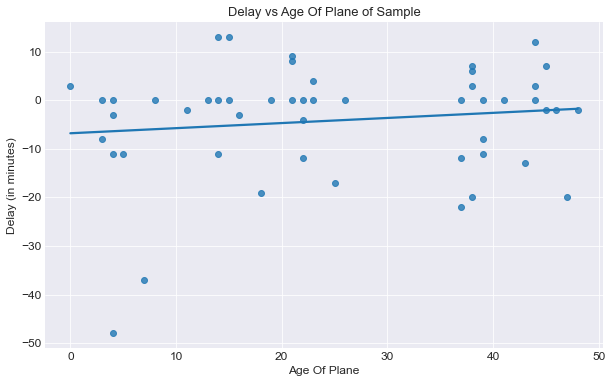

In [32]:
plt.figure(figsize=(10,6))
sns.regplot(data=sample_scatter, x='AgeOfPlane', y='q2Delay', ci=None)
plt.title("Delay vs Age Of Plane of Sample", size=13)
plt.xlabel("Age Of Plane", size=12)
plt.ylabel("Delay (in minutes)", size=12)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

Even though the regression line of the scatterplot has a slight positive gradient, there does not seem to be a clear pattern in the relationship between delays and age of the planes in the sample.

A hypothesis test was performed to test whether there is a significant relationship between delays and age of the planes.

Performing a correlation test between total delay and age of plane

In [33]:
corr, pvalue = pearsonr(df2['q2Delay'], df2['AgeOfPlane'])
print("Correlation:", corr)
print("p-value:", pvalue) 

Correlation: 0.034321230294884944
p-value: 0.0


From the above result, we can see that the sample correlation is 0.0343 with a p-value of 0. Hence, the null hypothesis of true correlation being smaller than or equal to 0 is rejected and it can be concluded that the true correlation is statistically greater than zero. However, even though the result is statistically significant, it is mainly due to the extreme sample size, and as the correlation is extremely low, near zero, there is no practical significance and meaningful interpretation to the test.

Therefore, it can be concluded that older planes do not suffer more delays.

# Q3) How does the number of people flying between different locations change over time?

As the dataset does not include the number of passengers on flight, this analysis will be looking at the change in number of flights between states throughout the years

Plotting number of flights over the years


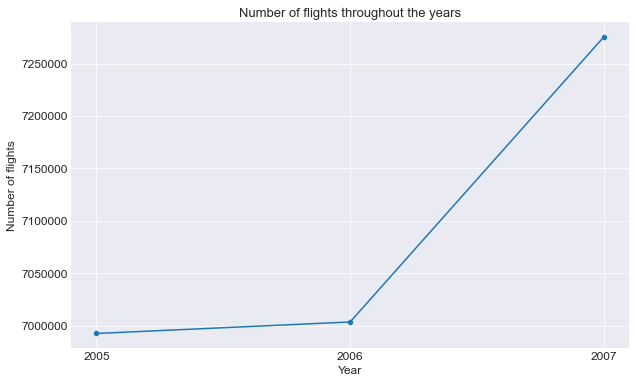

In [34]:
plt.figure(figsize=(10,6))
sns.lineplot(data=df.groupby('Year', as_index=False).size(), x='Year', y='size')
sns.scatterplot(data=df.groupby('Year', as_index=False).size(), x='Year', y='size')
plt.title("Number of flights throughout the years", size=13)
plt.ylabel("Number of flights", size=12)
plt.xlabel("Year", size=12)
plt.xticks(size=12)
plt.yticks(size=12)
plt.locator_params(axis='x', integer=True)
plt.ticklabel_format(style='plain', axis='y')

plt.show()

The number of flights has been increasing over the years.

Loading the airports.csv file

In [35]:
airports = pd.read_csv("airports.csv")

Creating a dataframe that shows the flights data with the states of departure and arrival airports.

In [36]:
ori_dest_df = df[['Year', 'Origin', 'Dest']]

ori_dest_df = ori_dest_df.join(airports[['iata','state']].set_index('iata'), on='Origin')
ori_dest_df = ori_dest_df.rename(columns={"state": "OriginState"})

ori_dest_df = ori_dest_df.join(airports[['iata','state']].set_index('iata'), on='Dest')
ori_dest_df = ori_dest_df.rename(columns={"state": "DestState"})

# Checking if there are any NAs
ori_dest_df.isna().any() # There are NA's in OriginState and DestState columns
ori_dest_df.loc[ori_dest_df['OriginState'].isna() | ori_dest_df['DestState'].isna()].drop_duplicates().head()

,Year,Origin,Dest,OriginState,DestState
170589,2005,SCE,CVG,NaN,KY
170658,2005,CVG,SCE,KY,NaN
203964,2005,CLD,LAX,NaN,CA
203965,2005,LAX,CLD,CA,NaN
407751,2005,MSN,MQT,WI,NaN


We can see that there are airports with missing states from the airports.csv file from the table above.

Checking airports with missing states

In [37]:
ori_dest_df.loc[ori_dest_df['OriginState'].isna(), ['Origin']].drop_duplicates()

,Origin
170589,SCE
203964,CLD
416060,MQT
1539829,HHH


In [38]:
ori_dest_df.loc[ori_dest_df['DestState'].isna(), ['Dest']].drop_duplicates()

,Dest
170658,SCE
203965,CLD
407751,MQT
1539814,HHH


From both of the table, we can see that SCE, CLD, MQT, and HHH airports have missing states. They are located in Pennsylvania (PA), California (CA), Michigan (MI), and South Carolina (SC) respectively.

Filling up the states of airports with missing data

In [39]:
airports.loc[airports['iata'] == "SCE", 'state'] = "PA"
airports.loc[airports['iata'] == "CLD", 'state'] = "CA"
airports.loc[airports['iata'] == "MQT", 'state'] = "MI"
airports.loc[airports['iata'] == "HHH", 'state'] = "SC"

ori_dest_df = df[['Year', 'Origin', 'Dest']]

ori_dest_df = ori_dest_df.join(airports[['iata','state']].set_index('iata'), on='Origin')
ori_dest_df = ori_dest_df.rename(columns={"state": "OriginState"})

ori_dest_df = ori_dest_df.join(airports[['iata','state']].set_index('iata'), on='Dest')
ori_dest_df = ori_dest_df.rename(columns={"state": "DestState"})

ori_dest_df.isna().any() # There are no longer any NA's in OriginState and DestState columns

Year           False
Origin         False
Dest           False
OriginState    False
DestState      False
dtype: bool

Performing data wrangling for visualisation

In [40]:
ori_dest_df_wide = ori_dest_df.groupby(['Year','OriginState','DestState'], as_index=False).size()
ori_dest_df_wide = ori_dest_df_wide.pivot_table(index=['OriginState','DestState'], values='size', columns='Year').add_prefix("flightcounts_").reset_index().rename_axis(None, axis=1)
ori_dest_df_wide.head()

,OriginState,DestState,flightcounts_2005,flightcounts_2006,flightcounts_2007
0,AK,AK,26204.0,25669.0,25625.0
1,AK,AZ,386.0,358.0,358.0
2,AK,CA,336.0,492.0,514.0
3,AK,CO,755.0,603.0,533.0
4,AK,GA,101.0,106.0,107.0


In [41]:
# Creating rows for states which do not have flights to/from the other states
for i in ori_dest_df_wide['OriginState'].unique():
    for j in ori_dest_df_wide['OriginState'].unique():
        if len(ori_dest_df_wide.loc[(ori_dest_df_wide['OriginState']==i) & (ori_dest_df_wide['DestState']==j)])==0:
            ori_dest_df_wide = ori_dest_df_wide.append(pd.DataFrame({'OriginState': [i],
                                                           'DestState': [j]}))

ori_dest_df_wide.reset_index(drop=True, inplace=True)
ori_dest_df_wide.tail()

,OriginState,DestState,flightcounts_2005,flightcounts_2006,flightcounts_2007
2699,WY,VT,NaN,NaN,NaN
2700,WY,WA,NaN,NaN,NaN
2701,WY,WI,NaN,NaN,NaN
2702,WY,WV,NaN,NaN,NaN
2703,WY,WY,NaN,NaN,NaN


In [42]:
# Calculating the difference in flights in 2007 compared to 2005
for i in range(0,len(ori_dest_df_wide)):
        if pd.isna(ori_dest_df_wide.loc[i, 'flightcounts_2005']):
            ori_dest_df_wide.loc[i, 'flightsincrease'] = ori_dest_df_wide.loc[i, 'flightcounts_2007']
        else:
            ori_dest_df_wide.loc[i, 'flightsincrease'] = ori_dest_df_wide.loc[i, 'flightcounts_2007'] - ori_dest_df_wide.loc[i, 'flightcounts_2005'] 

# Binning the values of the change in number of flights 
ori_dest_df_wide['flightsincreasefactor'] = pd.cut(ori_dest_df_wide['flightsincrease'], bins = [min(ori_dest_df_wide['flightsincrease']), -1000, -800,-600,-400,-200, -0.1 ,0.1, 200, 400,600,800,1000, max(ori_dest_df_wide['flightsincrease'])], labels=["≤ -1000","-801 to -1000","-601 to -800","-401 to -600", "-201 to -400","-1 to -200", "0", "1 to 200", "201 to 400", "401 to 600", "601 to 800", "801 to 1000", "≥ 1000"], include_lowest=True)
ori_dest_df_wide.head()

,OriginState,DestState,flightcounts_2005,flightcounts_2006,flightcounts_2007,flightsincrease,flightsincreasefactor
0,AK,AK,26204.0,25669.0,25625.0,-579.0,-401 to -600
1,AK,AZ,386.0,358.0,358.0,-28.0,-1 to -200
2,AK,CA,336.0,492.0,514.0,178.0,1 to 200
3,AK,CO,755.0,603.0,533.0,-222.0,-201 to -400
4,AK,GA,101.0,106.0,107.0,6.0,1 to 200


In [43]:
# Scraping data for longitude and latitude of states. 
# Data is scraped from https://developers.google.com/public-data/docs/canonical/states_csv
URL = "https://developers.google.com/public-data/docs/canonical/states_csv"
page = requests.get(URL)
soup = BeautifulSoup(page.text, "html.parser")
states = soup.find('div', {'class':'devsite-article-body'})

headers = []
for header in states.find_all('th'):
    title=header.text.strip()
    headers.append(title)
    
stateslonglat = pd.DataFrame(columns = headers)

for row in states.find_all('tr')[1:]:
    data = row.find_all('td')
    row_data = [td.text.strip() for td in data]
    length = len(stateslonglat)
    stateslonglat.loc[length] = row_data

stateslonglat['latitude'] = pd.to_numeric(stateslonglat['latitude'])
stateslonglat['longitude'] = pd.to_numeric(stateslonglat['longitude'])

stateslonglat.head()

,state,latitude,longitude,name
0,AK,63.588753,-154.493062,Alaska
1,AL,32.318231,-86.902298,Alabama
2,AR,35.201050,-91.831833,Arkansas
3,AZ,34.048928,-111.093731,Arizona
4,CA,36.778261,-119.417932,California


In [44]:
# Checking if there are any missing states in the dataset
print([i for i in pd.concat([ori_dest_df_wide['OriginState'], ori_dest_df_wide['OriginState']]).unique() if i not in stateslonglat['state'].tolist()])
# VI (Virgin Islands) has missing longitude and latitude values in the dataset

['VI']


In [45]:
# Adding VI's latitude and longitude
stateslonglat = pd.concat([stateslonglat, pd.DataFrame({'state': ["VI"], 
                                                        'latitude': 18.324130, 
                                                        'longitude': -64.919550, 
                                                        'name': "Virgin Islands"})],
                          axis=0).reset_index(drop=True)
stateslonglat.tail()

,state,latitude,longitude,name
48,WA,47.751074,-120.740139,Washington
49,WI,43.784440,-88.787868,Wisconsin
50,WV,38.597626,-80.454903,West Virginia
51,WY,43.075968,-107.290284,Wyoming
52,VI,18.324130,-64.919550,Virgin Islands


In [46]:
# Adding longitude and latitude to Origin State
ori_dest_df_wide = ori_dest_df_wide.join(stateslonglat.set_index('state'), on='OriginState').rename(columns={'latitude': 'Origin_lat',
                                                                                          'longitude': 'Origin_long'}).drop('name', axis=1)

# Adding longitude and latitude to Destination State
ori_dest_df_wide = ori_dest_df_wide.join(stateslonglat.set_index('state'), on='DestState').rename(columns={'latitude': 'Dest_lat',
                                                                                          'longitude': 'Dest_long'}).drop('name', axis=1)
ori_dest_df_wide.head()

,OriginState,DestState,flightcounts_2005,flightcounts_2006,flightcounts_2007,flightsincrease,flightsincreasefactor,Origin_lat,Origin_long,Dest_lat,Dest_long
0,AK,AK,26204.0,25669.0,25625.0,-579.0,-401 to -600,63.588753,-154.493062,63.588753,-154.493062
1,AK,AZ,386.0,358.0,358.0,-28.0,-1 to -200,63.588753,-154.493062,34.048928,-111.093731
2,AK,CA,336.0,492.0,514.0,178.0,1 to 200,63.588753,-154.493062,36.778261,-119.417932
3,AK,CO,755.0,603.0,533.0,-222.0,-201 to -400,63.588753,-154.493062,39.550051,-105.782067
4,AK,GA,101.0,106.0,107.0,6.0,1 to 200,63.588753,-154.493062,32.157435,-82.907123


Comparison of top flight routes by number of flights

In [47]:
# NOT INCLUDED IN REPORT

topflightroutes_2005 = ori_dest_df_wide.loc[:, ['OriginState', 'DestState', 'flightcounts_2005']].sort_values(by = 'flightcounts_2005', ascending=False).head(10).reset_index(drop=True)
topflightroutes_2005['Route'] = topflightroutes_2005['OriginState'] + " - " + topflightroutes_2005['DestState']
topflightroutes_2005.loc[:, ['Route', 'flightcounts_2005']]

topflightroutes_2006 = ori_dest_df_wide.loc[:, ['OriginState', 'DestState', 'flightcounts_2006']].sort_values(by = 'flightcounts_2006', ascending=False).head(10).reset_index(drop=True)
topflightroutes_2006['Route'] = topflightroutes_2006['OriginState'] + " - " + topflightroutes_2006['DestState']
topflightroutes_2006.loc[:, ['Route', 'flightcounts_2006']]

topflightroutes_2007 = ori_dest_df_wide.loc[:, ['OriginState', 'DestState', 'flightcounts_2007']].sort_values(by = 'flightcounts_2007', ascending=False).head(10).reset_index(drop=True)
topflightroutes_2007['Route'] = topflightroutes_2007['OriginState'] + " - " + topflightroutes_2007['DestState']
topflightroutes_2007.loc[:, ['Route', 'flightcounts_2007']]

,Route,flightcounts_2007
0,CA - CA,368015.0
1,TX - TX,247554.0
2,HI - HI,104108.0
3,AZ - CA,72059.0
4,CA - AZ,71253.0
5,CA - NV,68279.0
6,GA - FL,68113.0
7,FL - GA,67978.0
8,NV - CA,67839.0
9,TX - CA,56438.0


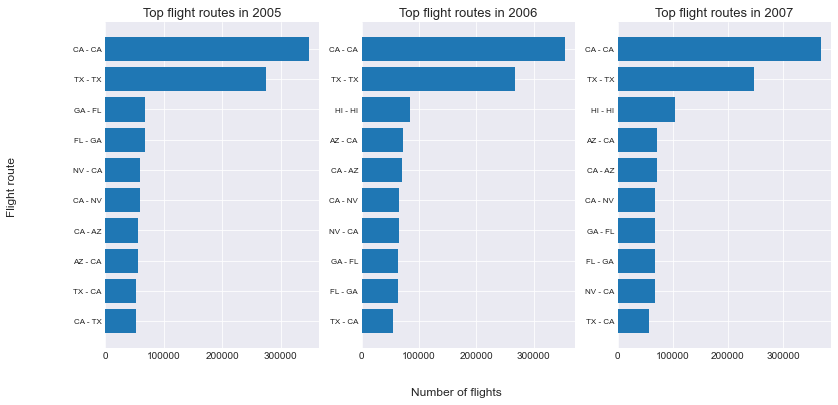

In [48]:
# NOT INCLUDED IN REPORT

fig, ax = plt.subplots(1, 3, figsize=(13, 6))

ax[0].barh(topflightroutes_2005['Route'], topflightroutes_2005['flightcounts_2005'])
ax[0].invert_yaxis()
ax[0].set_title("Top flight routes in 2005", size=13)
ax[0].tick_params(axis='y', which='major', labelsize=8)
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(4))

ax[1].barh(topflightroutes_2006['Route'], topflightroutes_2006['flightcounts_2006'])
ax[1].invert_yaxis()
ax[1].set_title("Top flight routes in 2006", size=13)
ax[1].tick_params(axis='y', which='major', labelsize=8)

ax[1].xaxis.set_major_locator(ticker.MaxNLocator(4))

ax[2].barh(topflightroutes_2007['Route'], topflightroutes_2007['flightcounts_2007'])
ax[2].invert_yaxis()
ax[2].set_title("Top flight routes in 2007", size=13)
ax[2].tick_params(axis='y', which='major', labelsize=8)
ax[2].xaxis.set_major_locator(ticker.MaxNLocator(4))


fig.supxlabel("Number of flights")
fig.supylabel("Flight route")


plt.show()

Plotting heatmap to show the change in number of flights from 2005 to 2007.

In [49]:
ori_dest_df_wider = ori_dest_df_wide.loc[:, ['OriginState', 'DestState', 'flightsincrease']]
ori_dest_df_wider = ori_dest_df_wider.pivot_table(index=['OriginState'], columns=['DestState'], values='flightsincrease')
ori_dest_df_wider.head()

DestState,AK,AL,AR,AZ,CA,CO,CT,DE,FL,GA,...,TN,TX,UT,VA,VI,VT,WA,WI,WV,WY
OriginState,,,,,,,,,,,,,,,,,,,,,
AK,-579.0,NaN,NaN,-28.0,178.0,-222.0,NaN,NaN,NaN,6.0,...,NaN,109.0,-417.0,NaN,NaN,NaN,110.0,NaN,NaN,NaN
AL,NaN,NaN,NaN,0.0,NaN,528.0,NaN,NaN,-248.0,-1961.0,...,3361.0,1871.0,161.0,-760.0,NaN,NaN,NaN,NaN,NaN,NaN
AR,NaN,NaN,NaN,1.0,75.0,113.0,NaN,NaN,342.0,384.0,...,905.0,-2087.0,-647.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN
AZ,-26.0,3.0,0.0,14138.0,16942.0,7005.0,-61.0,NaN,-333.0,574.0,...,719.0,3829.0,-1587.0,-186.0,NaN,NaN,221.0,-74.0,NaN,NaN
CA,177.0,NaN,89.0,15937.0,20034.0,7790.0,183.0,NaN,1224.0,-729.0,...,-161.0,3427.0,-476.0,-2122.0,NaN,NaN,3594.0,-323.0,NaN,3.0


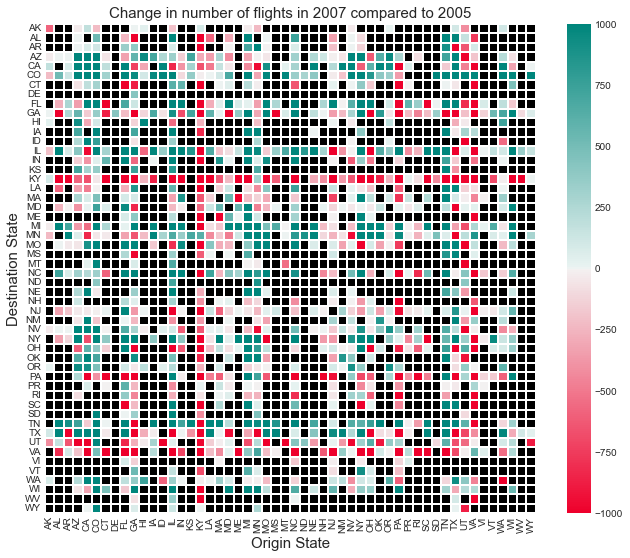

In [50]:
heatmapcolor = sns.diverging_palette(10, 180, s=100, as_cmap=True)

plt.figure(figsize=(11,9))
heatmap = sns.heatmap(data=ori_dest_df_wider, cmap=heatmapcolor, xticklabels=True, yticklabels=True, center=0, vmin=-1000, vmax=1000, linecolor="white", linewidths=0.005)
heatmap.set_facecolor('black')
plt.title("Change in number of flights in 2007 compared to 2005", size=15)
plt.xlabel("Origin State", size=15)
plt.ylabel("Destination State", size=15)
plt.show()

Plotting change in number of flights over different states.

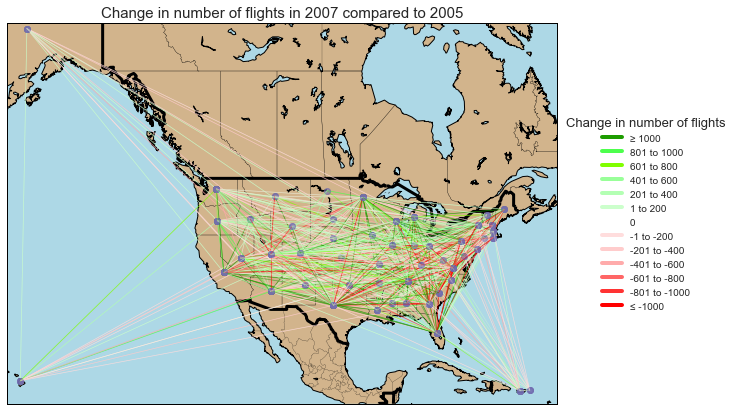

In [51]:
# NOT INCLUDED IN REPORT

plt.figure(figsize=(14,7))
plt.title("Change in number of flights in 2007 compared to 2005", size=15)

# Plotting geographical map
m = Basemap(projection='merc',llcrnrlon=-158,llcrnrlat=16,urcrnrlon=-60, urcrnrlat=64, lat_ts=0, resolution='l',suppress_ticks=True)
m.drawcountries(linewidth=3)
m.drawstates(linewidth=0.2)
m.drawcoastlines(linewidth=1)
m.fillcontinents(color='tan',lake_color='lightblue')
m.drawmapboundary(fill_color='lightblue')

# Mapping change of flights to color for use later
color_mapping = {'≤ -1000': '#ff0000',
                 '-801 to -1000': '#ff3333',
                 '-601 to -800': '#ff6666',
                 '-401 to -600': '#ffabab',
                 '-201 to -400': '#ffcccc',
                 '-1 to -200': '#ffdddd',
                 '0': '#FFFFFF',
                 '1 to 200': '#ccffcc',
                 '201 to 400': '#b3ffb3',
                 '401 to 600': '#99ff99',
                 '601 to 800': '#80ff00',
                 '801 to 1000': '#4dff4d',
                 '≥ 1000': '#1d9c00'
                }

# Plotting the lines to show change in number of flights
for i in range(len(ori_dest_df_wide)):
    if ori_dest_df_wide.loc[i, 'OriginState'] == ori_dest_df_wide.loc[i, 'DestState'] or pd.isna(ori_dest_df_wide.loc[i, 'flightsincreasefactor']):
        continue        
    else:
        lat = [ori_dest_df_wide.loc[i, 'Origin_lat'], ori_dest_df_wide.loc[i, 'Dest_lat']]
        long = [ori_dest_df_wide.loc[i, 'Origin_long'], ori_dest_df_wide.loc[i, 'Dest_long']]
        x, y = m(long, lat)
        m.plot(x, y, '-', markersize=5, linewidth=0.7, alpha=0.5, color = color_mapping[ori_dest_df_wide.loc[i, 'flightsincreasefactor']])
        m.plot(x, y, 'o', color='#746FB2', alpha=0.1)

# Creating legend
custom_legend = [Line2D([0], [0], color='#1d9c00', lw=4),
                 Line2D([0], [0], color='#4dff4d', lw=4),
                 Line2D([0], [0], color='#80ff00', lw=4),
                 Line2D([0], [0], color='#99ff99', lw=4),
                 Line2D([0], [0], color='#b3ffb3', lw=4),
                 Line2D([0], [0], color='#ccffcc', lw=4),
                 Line2D([0], [0], color='#FFFFFF', lw=4),
                 Line2D([0], [0], color='#ffdddd', lw=4),
                 Line2D([0], [0], color='#ffcccc', lw=4),
                 Line2D([0], [0], color='#ffabab', lw=4),
                 Line2D([0], [0], color='#ff6666', lw=4),
                 Line2D([0], [0], color='#ff3333', lw=4),
                 Line2D([0], [0], color='#ff0000', lw=4)]

plt.legend(custom_legend, ['≥ 1000', '801 to 1000', '601 to 800', '401 to 600', '201 to 400', '1 to 200', '0',
                          '-1 to -200', '-201 to -400', '-401 to -600', '-601 to -800', '-801 to -1000', '≤ -1000'],
           loc = 'center left', bbox_to_anchor=(1, 0.5), title="Change in number of flights", title_fontsize=13)

plt.show()

Zooming in on only contiguous United States

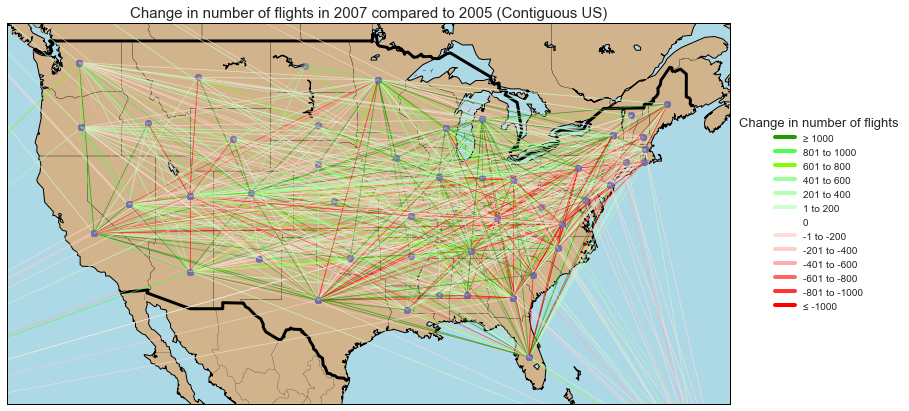

In [52]:
plt.figure(figsize=(14,7))
plt.title("Change in number of flights in 2007 compared to 2005 (Contiguous US)", size=15)
m = Basemap(projection='merc',llcrnrlon=-127,llcrnrlat=24,urcrnrlon=-64,
urcrnrlat=50, lat_ts=0, resolution='l',suppress_ticks=True)
m.drawcountries(linewidth=3)
m.drawstates(linewidth=0.2)
m.drawcoastlines(linewidth=1)
m.fillcontinents(color='tan',lake_color='lightblue')
m.drawmapboundary(fill_color='lightblue')

for i in range(len(ori_dest_df_wide)):
    if ori_dest_df_wide.loc[i, 'OriginState'] == ori_dest_df_wide.loc[i, 'DestState'] or pd.isna(ori_dest_df_wide.loc[i, 'flightsincreasefactor']):
        continue        
    else:
        lat = [ori_dest_df_wide.loc[i, 'Origin_lat'], ori_dest_df_wide.loc[i, 'Dest_lat']]
        long = [ori_dest_df_wide.loc[i, 'Origin_long'], ori_dest_df_wide.loc[i, 'Dest_long']]
        x, y = m(long, lat)
        m.plot(x, y, '-', markersize=5, linewidth=0.7, alpha=0.5, color = color_mapping[ori_dest_df_wide.loc[i, 'flightsincreasefactor']])
        m.plot(x, y, 'o', color='#746FB2', alpha=0.1)
        
plt.legend(custom_legend, ['≥ 1000', '801 to 1000', '601 to 800', '401 to 600', '201 to 400', '1 to 200', '0',
                          '-1 to -200', '-201 to -400', '-401 to -600', '-601 to -800', '-801 to -1000', '≤ -1000'],
           loc = 'center left', bbox_to_anchor=(1, 0.5), title="Change in number of flights", title_fontsize=13)

plt.show()

Plotting presence of flights routes between states

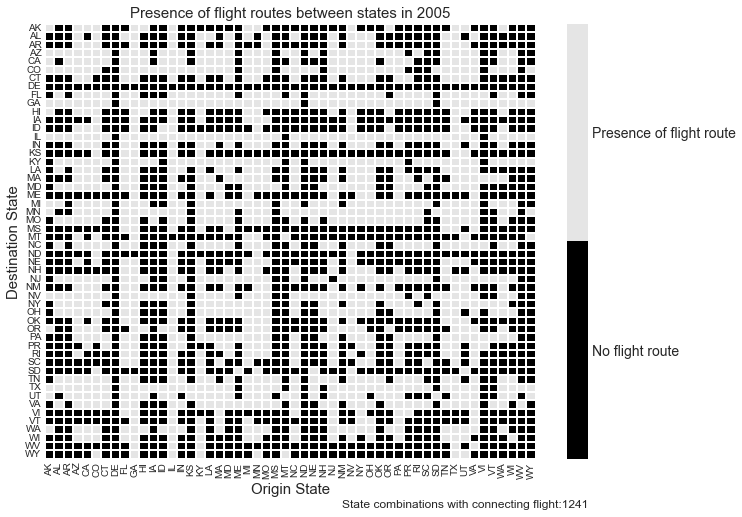

In [53]:
statescombi_df_2005 = pd.concat([ori_dest_df_wide.loc[:, ['OriginState', 'DestState']], 
                            ori_dest_df_wide.loc[:, ['flightcounts_2005']].notna()], axis=1)
statescombi_df_2005 = statescombi_df_2005.pivot_table(index=['DestState'], columns=['OriginState'], values='flightcounts_2005') 
# 1 represents presence of flight between Origin and Dest States, 0 otherwise

heatmapcolor2 = ['black', '#E5E5E5']

plt.figure(figsize=(11,8))
heatmap_2005 = sns.heatmap(data=statescombi_df_2005, cmap=heatmapcolor2, xticklabels=True, yticklabels=True, center=0.5, linecolor="white", linewidths=0.005)
heatmap_2005.set_facecolor('black')
plt.title("Presence of flight routes between states in 2005", size=15)
plt.xlabel("Origin State", size=15)
plt.ylabel("Destination State", size=15)
colorbar = heatmap_2005.collections[0].colorbar
colorbar.set_ticks([0.25,0.75])
colorbar.set_ticklabels(['No flight route', 'Presence of flight route'], size=14)
plt.gcf().text(0.5, 0.04, "State combinations with connecting flight:" + str(int(statescombi_df_2005.values.sum())), fontsize=12)
plt.show()

In [54]:
statescombi_df_2006 = ori_dest_df_wide.copy()
statescombi_df_2007 = ori_dest_df_wide.copy()

# Comparing presence of flight to the previous year. If both years has flight, 'Change' takes 1.
# If last year does not have flight but this year does, it takes 2. If last year has flight but this year does not,
# it takes -1. If both years does not have flight, it takes 0.
for i in range(len(statescombi_df_2006)):
    if (np.isnan(statescombi_df_2006.loc[i, 'flightcounts_2006']) == False) and (np.isnan(statescombi_df_2006.loc[i, 'flightcounts_2005']) == True):
        statescombi_df_2006.loc[i, 'Change'] = 2
    elif (np.isnan(statescombi_df_2006.loc[i, 'flightcounts_2006']) == True) and (np.isnan(statescombi_df_2006.loc[i, 'flightcounts_2005']) == False):
        statescombi_df_2006.loc[i, 'Change'] = -1
    elif (np.isnan(statescombi_df_2006.loc[i, 'flightcounts_2006']) == True) and (np.isnan(statescombi_df_2006.loc[i, 'flightcounts_2005']) == True):
        statescombi_df_2006.loc[i, 'Change'] = 0
    else:
        statescombi_df_2006.loc[i, 'Change'] = 1

for i in range(len(statescombi_df_2007)):
    if (np.isnan(statescombi_df_2007.loc[i, 'flightcounts_2007']) == False) and (np.isnan(statescombi_df_2007.loc[i, 'flightcounts_2006']) == True):
        statescombi_df_2007.loc[i, 'Change'] = 2
    elif (np.isnan(statescombi_df_2007.loc[i, 'flightcounts_2007']) == True) and (np.isnan(statescombi_df_2007.loc[i, 'flightcounts_2006']) == False):
        statescombi_df_2007.loc[i, 'Change'] = -1
    elif (np.isnan(statescombi_df_2007.loc[i, 'flightcounts_2007']) == True) and (np.isnan(statescombi_df_2007.loc[i, 'flightcounts_2006']) == True):
        statescombi_df_2007.loc[i, 'Change'] = 0
    else:
        statescombi_df_2007.loc[i, 'Change'] = 1
        
statescombi_df_2006 = statescombi_df_2006[['OriginState', 'DestState', 'Change']]
statescombi_df_2006 = statescombi_df_2006.pivot_table(index=['DestState'], columns=['OriginState'], values='Change')

statescombi_df_2007 = statescombi_df_2007[['OriginState', 'DestState', 'Change']]
statescombi_df_2007 = statescombi_df_2007.pivot_table(index=['DestState'], columns=['OriginState'], values='Change')

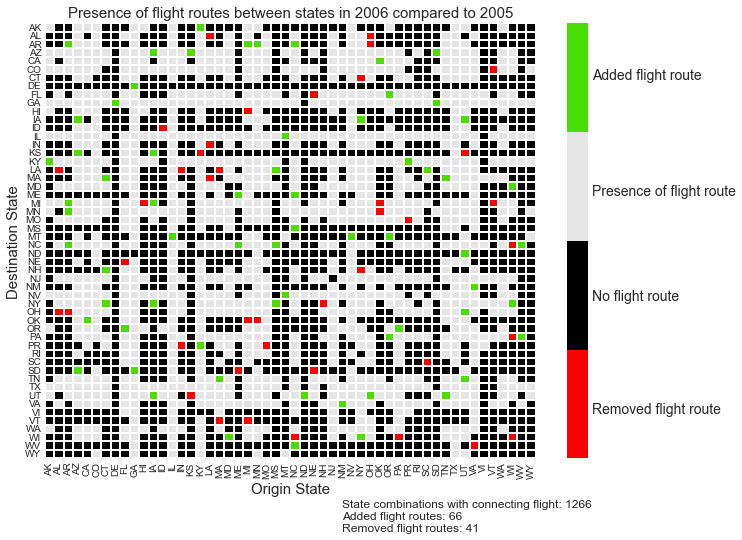

In [55]:
heatmapcolor3 =["#ff0000","black", "#E5E5E5", "#4ADE00"]
heatmaplabels = ["Removed flight route", "No flight route", "Presence of flight route", "Added flight route"]

plt.figure(figsize=(11,8))
heatmap_2006 = sns.heatmap(data=statescombi_df_2006, cmap=heatmapcolor3, xticklabels=True, yticklabels=True, center=0.5, linecolor="white", linewidths=0.005)
heatmap_2006.set_facecolor('black')
plt.title("Presence of flight routes between states in 2006 compared to 2005", size=15)
plt.xlabel("Origin State", size=15)
plt.ylabel("Destination State", size=15)
colorbar = heatmap_2006.collections[0].colorbar
colorbar.set_ticks([-0.65,0.125, 0.85, 1.65])
colorbar.set_ticklabels(heatmaplabels, size=14)
plt.gcf().text(0.5, -0.001 , "State combinations with connecting flight: " + str((statescombi_df_2006.values == 2).sum() + (statescombi_df_2006.values == 1).sum()) 
               + "\nAdded flight routes: " + str((statescombi_df_2006.values == 2).sum())
               + "\nRemoved flight routes: " + str((statescombi_df_2006.values == -1).sum()), fontsize=12)
plt.show()

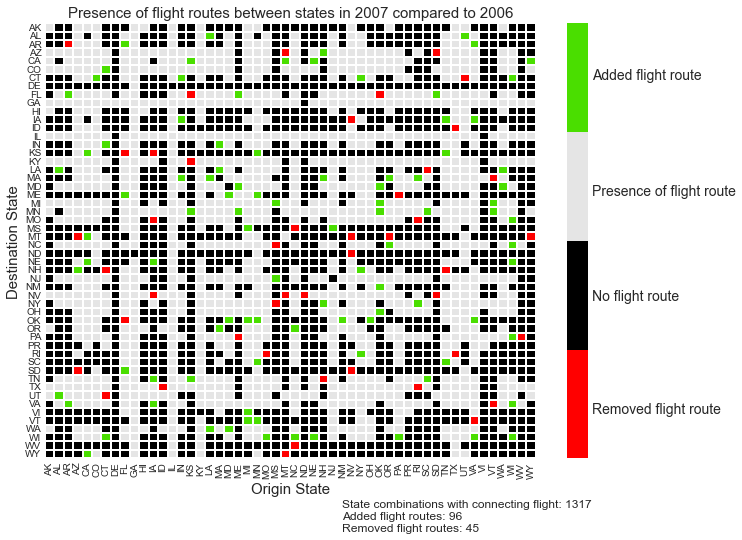

In [56]:
plt.figure(figsize=(11,8))
heatmap_2007 = sns.heatmap(data=statescombi_df_2007, cmap=heatmapcolor3, xticklabels=True, yticklabels=True, center=0.5, linecolor="white", linewidths=0.005)
heatmap_2007.set_facecolor('black')
plt.title("Presence of flight routes between states in 2007 compared to 2006", size=15)
plt.xlabel("Origin State", size=15)
plt.ylabel("Destination State", size=15)
colorbar = heatmap_2007.collections[0].colorbar
colorbar.set_ticks([-0.65,0.125, 0.85, 1.65])
colorbar.set_ticklabels(heatmaplabels, size=14)
plt.gcf().text(0.5, -0.001, "State combinations with connecting flight: " + str((statescombi_df_2007.values == 2).sum() + (statescombi_df_2007.values == 1).sum()) 
               + "\nAdded flight routes: " + str((statescombi_df_2007.values == 2).sum())
               + "\nRemoved flight routes: " + str((statescombi_df_2007.values == -1).sum()), fontsize=12)
plt.show()

From the line graph, the number of flights has been increasing over the years.

From the heatmap, we can see which are the flight routes that have increased or decreased number of flights compared to 2005. The black tiles (representing NAs) are states that do not have connecting flights in 2007. 

The map shows a higher concentration of red lines within the East Coast, indicating that there are more number of flight decreases in the area.

The tile shows the the states which have connecting flights and which do not. The combinations of states which have connecting flights have also increased over the years as shown on the bottom right corner. There were 1241 state combinations with connecting flight in 2005 and it increased to 1317 in 2007, indicating that the flight routes are getting more interconnected. This means that there are now more direct flights between states and passengers require fewer flight transfers to get to their destinations.

In conclusion, the number of people flying, which can be implied by the number of flights, between different locations have been increasing over the years with the addition of new flight routes connecting more states. However, one notable point is that the flights within the East Coast seem to have decreased over the years.

# Q4) Can you detect cascading failures as delays in one airport create delays in others?

According to the Bureau of Transportation Statistics, LateAircraftDelay is the delay of "a previous flight with same aircraft arrived late, causing the present flight to depart late" and "flights are on-time if they depart from the gate or arrive at the gate less than 15 minutes after their scheduled departure or arrival times". Hence, a flight is considered to have propagated delay if it arrived late to the origin airport (denoted by positive LateAircraftDelay) and also arrived late at the next destination airport (more than 15 minutes of ArrDelay). To identify cascading delays that are caused by the airports, flights with propagated delay and ArrDelay larger than the sum of LateAircraftDelay, WeatherDelay, and CarrierDelay (i.e. delays which are not caused by the airports) are filtered.

In [57]:
df4 = df.copy()

# Filtering flights with positive LateAircraftDelay, ArrDelay > 15 minutes, 
# and ArrDelay > LateAircraftDelay + WeatherDelay + CarrierDelay
df4['LateAircraftDelay + WeatherDelay + CarrierDelay'] = df4['LateAircraftDelay'] + df4['WeatherDelay'] + df4['CarrierDelay']

df4 = df4[(df4['LateAircraftDelay']>0) &
              (df4['ArrDelay']>15) & 
              (df4['ArrDelay']> df4['LateAircraftDelay + WeatherDelay + CarrierDelay'])]

In [58]:
# Example flight with cascading delay
df4.loc[(df4['LateAircraftDelay + WeatherDelay + CarrierDelay'] != df4['LateAircraftDelay']) & (df4['WeatherDelay'] != 0) & (df4['CarrierDelay'] != 0)][['Year', 'Month', 'DayofMonth', 'FlightNum', 'Origin', 'Dest', 'ArrDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']].head(1)

,Year,Month,DayofMonth,FlightNum,Origin,Dest,ArrDelay,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
30726,2005,1,20,180,ORD,PIT,155.0,1,5,26,0,123


From the above dataframe, we can see that the flight arrived at the origin airport late by 123 minutes but arrived at the destination airport late by 155 minutes, an additional 32 minutes. Since there was also CarrierDelay of 1 minute and WeatherDelay of 5 minutes, the extra 26 minutes after deduction of the two delays indicates that the flight was cascading-delayed and the extra time must have been caused by the inefficiency in one of or both the airports. For example, the origin and/or destination airports do not have runway for the late aircraft to land or takeoff, or it could also be caused by other delays within the airport (which would be denoted by positive NASDelay or SecurityDelay).

To identify airports that are most likely to cause cascading failures, the flight routes are filtered based on three conditions:
1) The average cascading delay of the flight route is at least 10 minutes

2) At least 10% of flights of the route has cascading delay

3) The flights count of the route is more than or equal to 1000

In [59]:
# Calculating the number of cascading-delayed flights
df4= df4.groupby(['Origin', 'Dest']).agg(avgcascadedelay = ('LateAircraftDelay + WeatherDelay + CarrierDelay', 'mean'), cascadedelay_count=('Origin', 'size')).sort_values(by='cascadedelay_count', ascending=False).reset_index()

# Calculating the flight count of all the flight routes
ori_dest_total_df = ori_dest_df.groupby(['Origin', 'Dest']).size().reset_index(name='flight_count')

# Combining the 2 dataframes to calculate percentage of cascading-delayed flights
df4 = pd.merge(df4, ori_dest_total_df,  how='left', left_on=['Origin','Dest'], right_on = ['Origin','Dest'])
df4 = df4[['Origin', 'Dest', 'avgcascadedelay', 'cascadedelay_count', 'flight_count']] # Rearrange columns
df4['cascadedelay_percentage'] = df4['cascadedelay_count'] / df4['flight_count'] * 100 # Calculating percentage of cascade-delayed flights

# Filtering flight routes with average cascading delays of at least 15 minutes,
# at least 10% of the flights having cascading delay and
# flight counts more than or equal to 1000
df4=df4[(df4['avgcascadedelay']>=15) & (df4['cascadedelay_percentage'] >= 10) & (df4['flight_count'] >= 1000)]
df4

,Origin,Dest,avgcascadedelay,cascadedelay_count,flight_count,cascadedelay_percentage
0,LGA,ORD,49.245452,3573,32309,11.058838
1,ORD,LGA,47.973357,3378,32221,10.483846
4,ORD,EWR,56.565287,2512,22410,11.209282
5,EWR,ORD,61.866747,2499,22778,10.971112
9,PHL,ORD,55.529062,2357,22153,10.639642
...,...,...,...,...,...,...
2047,LAS,SDF,30.975207,121,1092,11.080586
2068,LAS,MHT,34.449153,118,1092,10.805861
2086,EWR,HNL,39.594828,116,1080,10.740741
2088,EWR,BQN,69.137931,116,1067,10.871603


In [60]:
# Getting the total flight count (number of flights arriving to and departing from) in each airport
origin_counts = df.groupby('Origin', as_index=False).size().sort_values(by='size').rename(columns={"Origin": "Airport"})
destination_counts = df.groupby('Dest', as_index=False).size().sort_values(by='size').rename(columns={"Dest": "Airport"})
airport_counts = pd.concat([origin_counts, destination_counts]).groupby('Airport').aggregate(sum).sort_values(by='size', ascending=False).rename(columns={"size": "totalflight_count"})
airport_counts

,totalflight_count
Airport,
ATL,2441573
ORD,2091308
DFW,1767974
LAX,1385103
DEN,1289152
...,...
GLH,4
MKC,2
CKB,2


Plotting network visualisation of airports with cascading delays

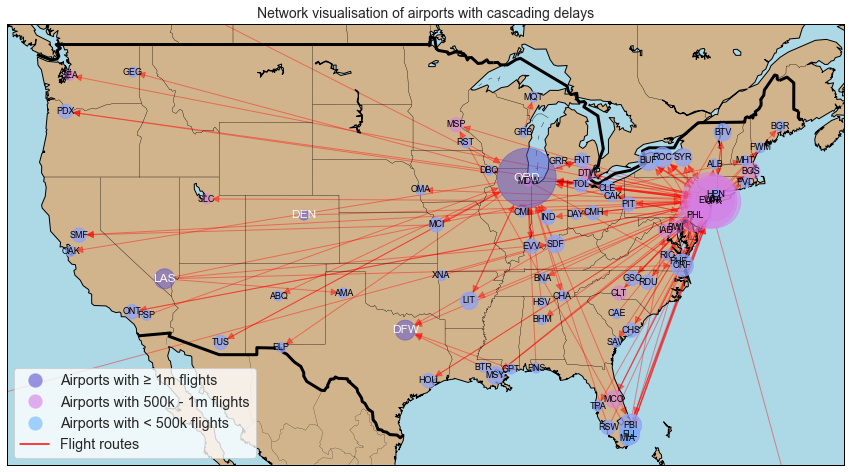

In [61]:
plt.figure(figsize=(15,15))
plt.title("Network visualisation of airports with cascading delays", size=14)

G = nx.from_pandas_edgelist(df4, source = 'Origin', target = 'Dest', edge_attr = 'cascadedelay_count', create_using = nx.DiGraph())

m = Basemap(projection='merc',llcrnrlon=-127,llcrnrlat=24,urcrnrlon=-64,
urcrnrlat=50, lat_ts=0, resolution='l',suppress_ticks=True)
m.drawcountries(linewidth=3)
m.drawstates(linewidth=0.2)
m.drawcoastlines(linewidth=1)
m.fillcontinents(color='tan',lake_color='lightblue')
m.drawmapboundary(fill_color='lightblue')

mx, my = m(airports['long'].values, airports['lat'].values)
pos = {}

for count, elem in enumerate (airports['iata']):
    pos[elem] = (mx[count], my[count])

d = dict(G.degree)

nx.draw_networkx_nodes(G, pos = pos, 
                       nodelist = [u for u, v in d.items() if airport_counts['totalflight_count'][u] >= 1000000],
                       node_size = [v*100 for u, v in d.items() if airport_counts['totalflight_count'][u] >= 1000000],
                       node_color = '#5c52d1', alpha = 0.5) 
                                                       
nx.draw_networkx_nodes(G, pos = pos, 
                       nodelist = [u for u, v in d.items() if airport_counts['totalflight_count'][u] < 1000000],
                       node_size = [v*100 for u, v in d.items() if airport_counts['totalflight_count'][u] < 1000000],
                       node_color = '#d67be8', alpha = 0.5)
                       
nx.draw_networkx_nodes(G, pos = pos, 
                       nodelist = [u for u, v in d.items() if airport_counts['totalflight_count'][u] < 500000],
                       node_size = [v*100 for u, v in d.items() if airport_counts['totalflight_count'][u] < 500000],
                       node_color = '#6bb7ff', alpha = 0.5)
    
nx.draw_networkx_labels(G, pos = pos, font_size=12, font_color='#fafafa',
                        labels = {x: x for x in G.nodes() if airport_counts['totalflight_count'][x] >= 1000000})

nx.draw_networkx_labels(G, pos = pos, font_size=9,  font_color='black',
                        labels = {x: x for x in G.nodes() if airport_counts['totalflight_count'][x] < 1000000})

nx.draw_networkx_edges(G, pos = pos, edge_color='red', alpha=0.4, arrows = True, arrowsize = 15,
                        node_size = [v*100 for u, v in d.items()])

l1 = Line2D([0], [0], linewidth=0, color="white", marker='o', markersize=15, markerfacecolor="#5c52d1", alpha=0.6)
l2 = Line2D([0], [0], linewidth=0, color="white", marker='o', markersize=15, markerfacecolor="#d67be8", alpha=0.6)
l3 = Line2D([0], [0], linewidth=0, color="white", marker='o', markersize=15, markerfacecolor="#6bb7ff", alpha=0.6)
l4 = Line2D([0], [0], color="red", marker='', markerfacecolor="green")


plt.legend((l1, l2, l3, l4), ("Airports with ≥ 1m flights", "Airports with 500k - 1m flights", "Airports with < 500k flights", "Flight routes"), loc=3, fontsize = 'x-large', frameon=True, facecolor='white')

plt.show()

In [62]:
# Checking number of degrees of DFW
d['DFW']

4

In [63]:
# Checking number of degrees of EWR
d['EWR']

31

In [64]:
# Checking number of flights for DFW
airport_counts['totalflight_count']["DFW"]

1767974

In [65]:
# Checking number of flights for EWR
airport_counts['totalflight_count']["EWR"]

902600

In [66]:
# Checking top airport
airport_counts.head(1)

,totalflight_count
Airport,
ATL,2441573


From the network visualisation, we can see which are the airports that are most likely to cause cascading delays. The size of the nodes represents the number of connections (edges) to the airport that meets the criteria set above. Hence, the larger the node, the more likely the airport causes cascading delays. For instance, looking at ORD, it has many incoming and outgoing flights with cascading delays. This means that the airport is inefficient in handling both inbound and outbound flights that were late.

Additionally, it can be seen that the number of flights handled by an airport, which is denoted by the colour of the node, does not determine the extent of the cascading delays. For example, comparing DFW and EWR (at the cluster of airports in the East), DFW is the 4th largest airport by number of flights and handles 95% more flights than EWR, but the size of the node of DFW is much smaller than EWR’s (DFW has 4 edges while EWR has 31). Furthermore, ATL, which has the highest number of flight counts, does not appear in the visualisation, indicating that a high volume of flights does not necessarily cause more delays. 

In conclusion, cascading failures can be detected and the airports shown in the above visualisation have critical points of failure, causing cascading failures that amplify existing delays to the next airport.

# Q5) Use the available variables to construct a model that predicts delays.

According to the Bureau of Transportation Statistics, "flights are on-time if they depart from the gate or arrive at the gate less than 15 minutes after their scheduled departure or arrival times". Hence for this analysis, a flight will be considered late if it arrives more than 15 minutes after its scheduled arrival time. A target variable column, 'Delayed', will be created which takes value 1 or 0. Delayed = 1 if ArrDelay exceeds 15 minutes, 0 otherwise. Only variables that are known prior to a flight’s scheduled departure will be used as features in the prediction. Binary classification will be performed to predict whether a flight will be delayed or not. 

Features that will be used to predict delays in a flight:

Categorical features: 
* Month - Month
* DayOfWeek - Day of Week 
* UniqueCarrier - Unique Carrier
* Origin - Origin airport*
* Dest - Destination airport*
* HourOfDay_Dep - Hourly interval based on scheduled departure time (CRSDepTime)
* HourOfDay_Arr - Hourly interval based on scheduled arrival time (CRSArrTime)

*Airports not in the top 100 airports by number of flights will be categorised as 'Others'

Numerical feature:
* Distance - Distance between airports (miles)

As there are too many airports and some airports have only a few flights, the top 100 airports by number of flights will remain as it is, and the rest will be grouped as 'Others' for the analysis. Due to the large dataset, a subsample of 100,000 random observations was used for the analysis. The 100,000 observations will be split into 70% as training set and 30% as test set. Logistic Regression, Gradient Boosting, Classification Tree, and Random Forest will be benchmarked to see which algorithm provides the best prediction.

In [67]:
# Preparing data frame to apply Machine Learning 
df5 = df.copy()

# Adding columns 'HourOfDay_Dep' and 'HourOfDay_Arr' to specify the hourly interval the 
# scheduled departure time (CRSDepTime) and scheduled arrival time (CRSArrTime) is in. 
df5['CRSDepTime'] = df5['CRSDepTime'].astype(str)
length_of_crsdeptime = df5['CRSDepTime'].str.len()
df5['HourOfDay_Dep'] = np.select([length_of_crsdeptime==4, length_of_crsdeptime==3, length_of_crsdeptime<3], [df5['CRSDepTime'].str[0:2], df5['CRSDepTime'].str[0:1], 0], np.nan)
df5['HourOfDay_Dep'] = df5['HourOfDay_Dep'].astype(int)

df5['CRSArrTime'] = df5['CRSArrTime'].astype(str)
length_of_crsarrtime = df5['CRSArrTime'].str.len()
df5['HourOfDay_Arr'] = np.select([length_of_crsarrtime==4, length_of_crsarrtime==3, length_of_crsarrtime<3], [df5['CRSArrTime'].str[0:2], df5['CRSArrTime'].str[0:1], 0], np.nan)
df5['HourOfDay_Arr'] = df5['HourOfDay_Arr'].astype(int)

df5['Delayed'] = np.where(df5['ArrDelay'] > 15, 1, 0) # Creating 'Delayed' column. Delayed = 1 if ArrDelay exceeds 15 minutes, 0 otherwise. 
df5 = df5[['Month', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest', 'Distance', 'HourOfDay_Dep', 'HourOfDay_Arr', 'Delayed']] # Keeping only columns that will be used as features and target variable.

# Getting largest 100 airports by number of flights
topairports = airport_counts.reset_index()['Airport'].head(100).tolist()
# Grouping airports not in the top 100 airports into 'Others'
df5['Origin'] = ['Others' if airport not in topairports else airport for airport in df5['Origin']]
df5['Dest'] = ['Others' if airport not in topairports else airport for airport in df5['Dest']]

# Selecting 100,000 random samples 
df5 = df5.sample(n=100000, replace=True, random_state=1)

features = ['Month', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest', 'Distance', 'HourOfDay_Dep', 'HourOfDay_Arr']
X = df5[features].copy()
y = df5['Delayed'].copy()
              
# Splitting data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)

Visualising counts of Delayed vs On Time flights

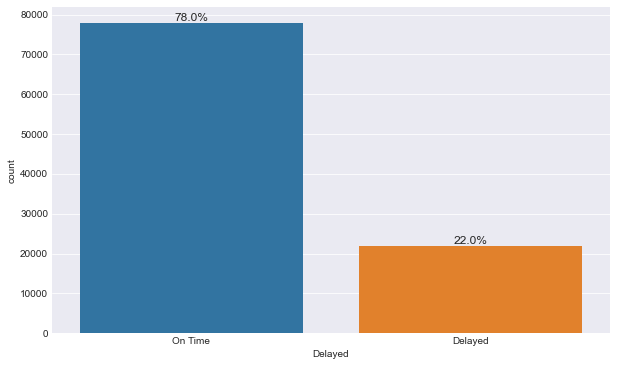

In [68]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x='Delayed', data=df5)
ax.set_xticklabels(['On Time','Delayed'])

for bars in ax.containers:    
    labels = [f'{v.get_height()/df5.Delayed.count()*100:0.1f}%' for v in bars]
    ax.bar_label(bars, labels=labels, label_type='edge', size=12)

plt.show()

There is an imbalance between delayed and on time flights.

In [69]:
# Data pre-processing

numerical_features = ['Distance']
# Applying SimpleImputer and StandardScaler into a pipeline 
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())])

categorical_features = ['Month', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest', 'HourOfDay_Dep', 'HourOfDay_Arr']
                        
# Applying SimpleImputer and OneHotEncoder to convert into dummy variables
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Merging the pipelines                    
data_transformer = ColumnTransformer( transformers=[
    ('numerical', numerical_transformer, numerical_features), 
    ('categorical', categorical_transformer, categorical_features)])

# Setting the parameters
param_grid = {
'data_transformer__numerical__imputer__strategy': ['mean', 'median'],
'data_transformer__categorical__imputer__strategy': ['constant','most_frequent']
}

# Logistic Regression
pipe_lr = Pipeline(steps=[('data_transformer', data_transformer),
                          ('pipe_lr', LogisticRegression(max_iter=10000))])

grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid) 
grid_lr.fit(X_train, y_train)

# Gradient Boosting
pipe_gdb = Pipeline(steps=[('data_transformer', data_transformer),
                           ('pipe_gdb', GradientBoostingClassifier(random_state=1))])
grid_gdb = GridSearchCV(pipe_gdb, param_grid=param_grid) 
grid_gdb.fit(X_train, y_train)

# Classification Tree
pipe_tree = Pipeline(steps=[('data_transformer', data_transformer),
                           ('pipe_tree', DecisionTreeClassifier(random_state=1))])
grid_tree = GridSearchCV(pipe_tree, param_grid=param_grid)
grid_tree.fit(X_train, y_train)

# Random Forest
pipe_rf = Pipeline(steps=[('data_transformer', data_transformer),
                           ('pipe_rf', RandomForestClassifier(random_state=1))])
grid_rf = GridSearchCV(pipe_rf, param_grid=param_grid)
grid_rf.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('data_transformer',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Distance']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                 

Plotting the ROC curves of the various models

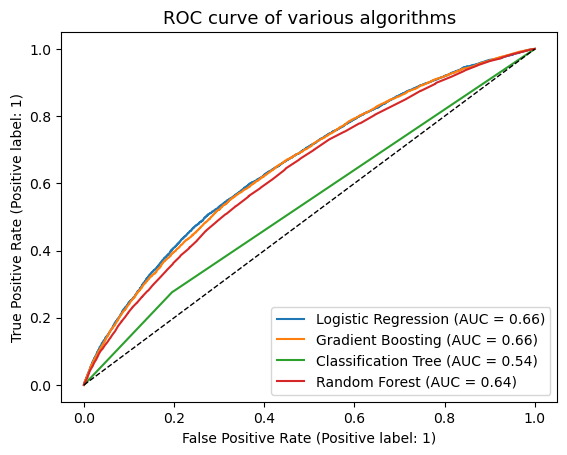

In [70]:
plt.style.use('default')

ax = plt.gca()

RocCurveDisplay.from_estimator(grid_lr, X_test, y_test, ax=ax, name='Logistic Regression')
RocCurveDisplay.from_estimator(grid_gdb, X_test, y_test, ax=ax, name='Gradient Boosting')
RocCurveDisplay.from_estimator(grid_tree, X_test, y_test, ax=ax, name='Classification Tree')
RocCurveDisplay.from_estimator(grid_rf, X_test, y_test, ax=ax, name='Random Forest')
        
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.title("ROC curve of various algorithms", size=13)

plt.show()

Classification Tree performed the worst with area under the ROC curve (AUC) just slightly above 0.5, indicating that the model has almost no predictive power, hence we will just look at the other 3 models.

Confusion Matrix of the 3 models (Scikit's default confusion matrix)

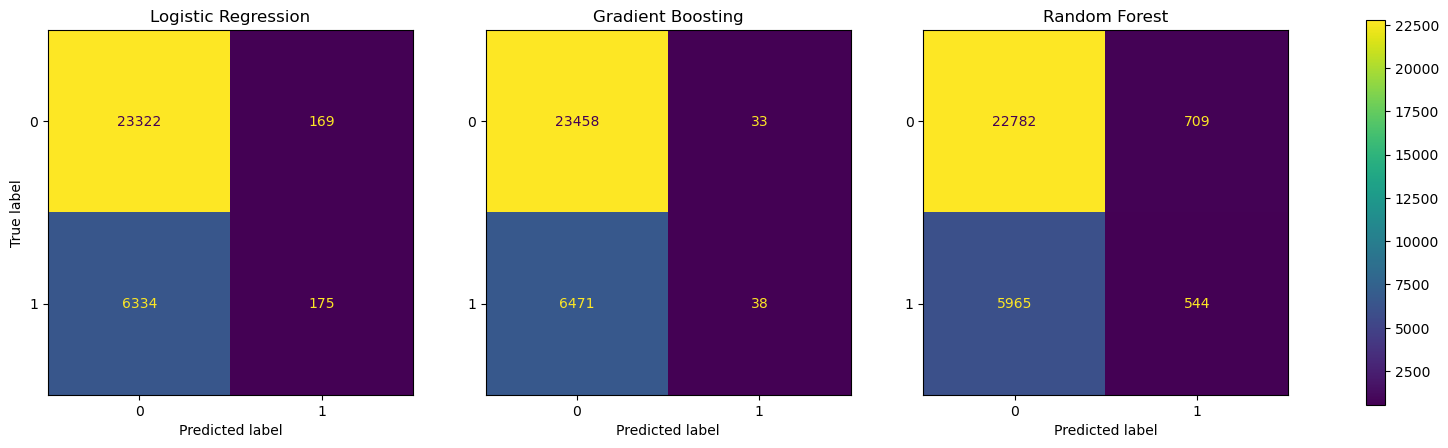

In [71]:
# NOT INCLUDED IN REPORT

classifiers = {
    "Logistic Regression": grid_lr,
    "Gradient Boosting": grid_gdb,
    "Random Forest": grid_rf,
}

f, axes = plt.subplots(1, 3, figsize=(20, 5))

for i, (name, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(ax=axes[i])
    disp.ax_.set_title(name)
    disp.im_.colorbar.remove()
    if i != 0:
        disp.ax_.set_ylabel('')
f.colorbar(disp.im_, ax=axes)
    
plt.show()

Confusion Matrix of the 3 models (Improved)

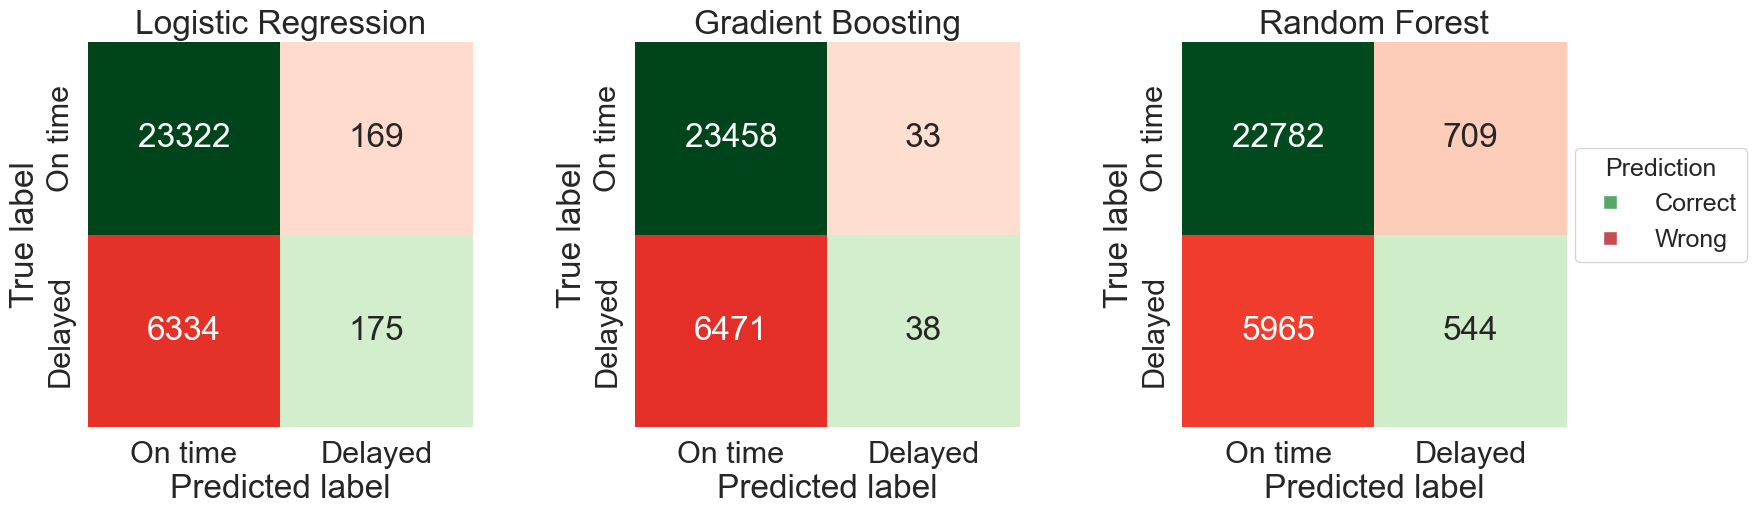

In [72]:
# Custom colormap for better representation of values
greencmap = mpl.cm.Greens(np.linspace(0,1,150))
greencmap = mpl.colors.ListedColormap(greencmap[30:150,:])
redcmap = mpl.cm.Reds(np.linspace(0,1,150))
redcmap = mpl.colors.ListedColormap(redcmap[20:100,:])

correct_prediction = np.array([], dtype='int64')
wrong_prediction = np.array([], dtype='int64')
for name, classifier in classifiers.items():
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    correct_prediction = np.append(correct_prediction, np.diagonal(cm))
    wrong_prediction = np.append(wrong_prediction, np.fliplr(cm).diagonal()) # To get better color representation for confusion matrix

sns.set(font_scale=2) # Scale up text size
f, axes = plt.subplots(1, 3, figsize=(20, 5))

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    mask = np.eye(*cm.shape, dtype=bool)
    sns.set(font_scale=2) # Scale up number size
    disp = sns.heatmap(cm, annot=True, mask=~mask, cmap=greencmap, vmin=min(correct_prediction), vmax=max(correct_prediction), fmt='d', cbar=False, square=True, ax=axes[i])
    disp = sns.heatmap(cm, annot=True, mask=mask, cmap=redcmap, vmin=min(wrong_prediction), vmax=max(wrong_prediction), fmt='d', cbar=False, square=True, xticklabels=['On time', 'Delayed'], yticklabels=['On time', 'Delayed'], ax=axes[i])
    disp.set_title(key)
    disp.set_xlabel("Predicted label")
    disp.set_ylabel("True label")
    
sns.set(font_scale=1.5) # Scale down legend size
c1 = Line2D([0], [0], linewidth=0, marker='s', color='white', markersize=10, markerfacecolor='g')
c2 = Line2D([0], [0], linewidth=0, marker='s', color='white', markersize=10, markerfacecolor='r')
plt.legend((c1, c2), ("Correct", "Wrong"), loc=(1.02,0.43), fontsize = 'medium', facecolor='white', title = "Prediction")
plt.show()

The confusion matrix (of Logistic Regression) is interpreted as follows: 
* row 1, column 1: 23322 on-time flights in the test set were correctly predicted by the model.
* row 2, column 1: 6334 delayed flights in the test set were incorrectly predicted by the model.
* row 1, column 2: 169 on-time flights in the test set were incorrectly predicted by the model.
* row 2, column 2: 175 delayed flights in the test set were correctly predicted by the model.

Performance of the 3 models

In [73]:
for name, classifier in classifiers.items():
    y_pred = classifier.predict(X_test)
    print(name + "'s accuracy: " + str(accuracy_score(y_test,y_pred)*100) + "%")
    print("Classfication report:\n" + classification_report(y_test, y_pred) + "\n")

Logistic Regression's accuracy: 78.32333333333334%
Classfication report:
              precision    recall  f1-score   support

           0       0.79      0.99      0.88     23491
           1       0.51      0.03      0.05      6509

    accuracy                           0.78     30000
   macro avg       0.65      0.51      0.46     30000
weighted avg       0.73      0.78      0.70     30000


Gradient Boosting's accuracy: 78.32000000000001%
Classfication report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     23491
           1       0.54      0.01      0.01      6509

    accuracy                           0.78     30000
   macro avg       0.66      0.50      0.44     30000
weighted avg       0.73      0.78      0.69     30000


Random Forest's accuracy: 77.75333333333333%
Classfication report:
              precision    recall  f1-score   support

           0       0.79      0.97      0.87     23491
           1       0.43 

The classification report shows the precision, recall, and F1 score of each class. 

As the data is highly imbalanced, with 78% of the flights being on time, and only 22% being delayed, the accuracy of the prediction is not a good measure of the performance of the model. For instance, if the model were to predict all the flights being on time, it would have an accuracy of 78% despite not predicting any delayed flights.

The best model is the one with the highest AUC. Looking at the ROC curves, Logistic Regression and Gradient Boosting have the same AUC, but the F1 scores of Logistic Regression are better.

In conclusion, among the 4 classifiers, Logistic Regression is the best at predicting whether a flight would be delayed.